In [13]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst, u_darrays as uda
import glob
from scipy import stats
import pickle as pkl
import salem
import pandas as pd

%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [8]:
chirps = cnst.other_drive+'HUARAZ/CHIRPS_onERA/*.nc'

fpath = cnst.FIGS + 'HUARAZ/'

fname = cnst.DATA +'HUARAZ/shapes/riosan_sel_one.shp'

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

ca = xr.open_mfdataset(chirps)
ca = ca.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

In [9]:
# some faff with ERA
def readERA(var):
    
    print('Opening', cnst.other_drive + 'HUARAZ/ERA5/hourly/15UTC'+var+'_15UTC_*.nc')
    u200orig = xr.open_mfdataset(cnst.other_drive + 'HUARAZ/ERA5/hourly/15UTC/'+var+'_15UTC_*.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [45]:
var = 'q850'
maps = readERA(var)
maps = maps.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/LStorage/global_water/other/HUARAZ/ERA5/hourly/15UTCq850_15UTC_*.nc


In [47]:
maps = maps['q']#.isel(expver=1).squeeze()

In [48]:
# get rio santa shape file mean
ca_rio_ts = ca.salem.roi(shape=sdf).mean(['latitude', 'longitude']).load()
era_rio_ts = maps.salem.roi(shape=sdf).mean(['latitude', 'longitude']).load()

In [49]:
# extract p95 routine
def get_percDates(x):
    p = x.where(x>1).quantile(0.95)
    return x.where(x > p, drop=True)

In [50]:
# get 95th percentile rainfall days with p95 defined per month
ca_out = ca_rio_ts['precip'].groupby(ca_rio_ts['time.month']).apply(get_percDates)

In [51]:
# chirps/ERA overlap dates
over = np.intersect1d(ca_out.where(np.isfinite(ca_out), drop=True).time, era_rio_ts.where(np.isfinite(era_rio_ts), drop=True).time)

In [52]:
era_rio_ts_ca = era_rio_ts.sel(time = over)
ca_out_ca = ca_out.sel(time=over)

In [53]:
#concentrate on February for now
month_ca = ca_out_ca.sel(time=ca_out_ca['time.month']==2)

In [54]:
# correlation routine
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box

    if bsingle:
        bb = b
    else:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])

    for lat in a.latitude.values:
        for lon in a.longitude.values:
            #print('latlon', lat, lon)
            aa = a.sel(latitude=lat, longitude=lon)
            pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)

            slope = pf#[0]

#             if (np.nansum(aa.values == 0) >= 10):
#                 p = np.nan
#                 r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [55]:
# calculate correlation day by day for extreme sample, no timeseries, lag option
def apply_day_corr(ds, ts,minus='0days', plus='0days'):

    dates = ts.where(np.isfinite(ts), drop=True).time
    wds = dates -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    wd_true = dates 
    
    print('wet', len(wds), len(wd_true))
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    wd_true = wd_true[x_ind]
    print('wet2', len(wds))

    all_wet = ds.sel(time=wds)
    
    #ts_dry = ts.sel(time=dd_true)
    ts_wet = ts.sel(time=wd_true)
    print('Entering corr calc')
    wcorr = corr(all_wet, ts_wet, bsingle=True)
    return wcorr

In [56]:
# calculate lagged day correlation +/- 5 days
series_pd = []
for num in np.arange(0,5)[::-1]:
    series_pd.append(apply_day_corr(ca['precip'], month_ca,  minus=str(num)+'days', plus='0days'))
for num in np.arange(1,6):
    series_pd.append(apply_day_corr(ca['precip'], month_ca, minus='0days', plus=str(num)+'days'))

wet 36 36
wet2 36
Entering corr calc
wet 36 36
wet2 36
Entering corr calc
wet 36 36
wet2 36
Entering corr calc
wet 36 36
wet2 36
Entering corr calc
wet 36 36
wet2 36
Entering corr calc


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


wet 36 36
wet2 36
Entering corr calc


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


wet 36 36
wet2 36
Entering corr calc


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


wet 36 36
wet2 36
Entering corr calc


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


wet 36 36
wet2 36
Entering corr calc


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


wet 36 36
wet2 36
Entering corr calc


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [42]:
#save correlated days
#pkl.dump(series, open(cnst.DATA + 'HUARAZ/emily_test/feb_tcw_dayVSday_corr.p', "wb"))

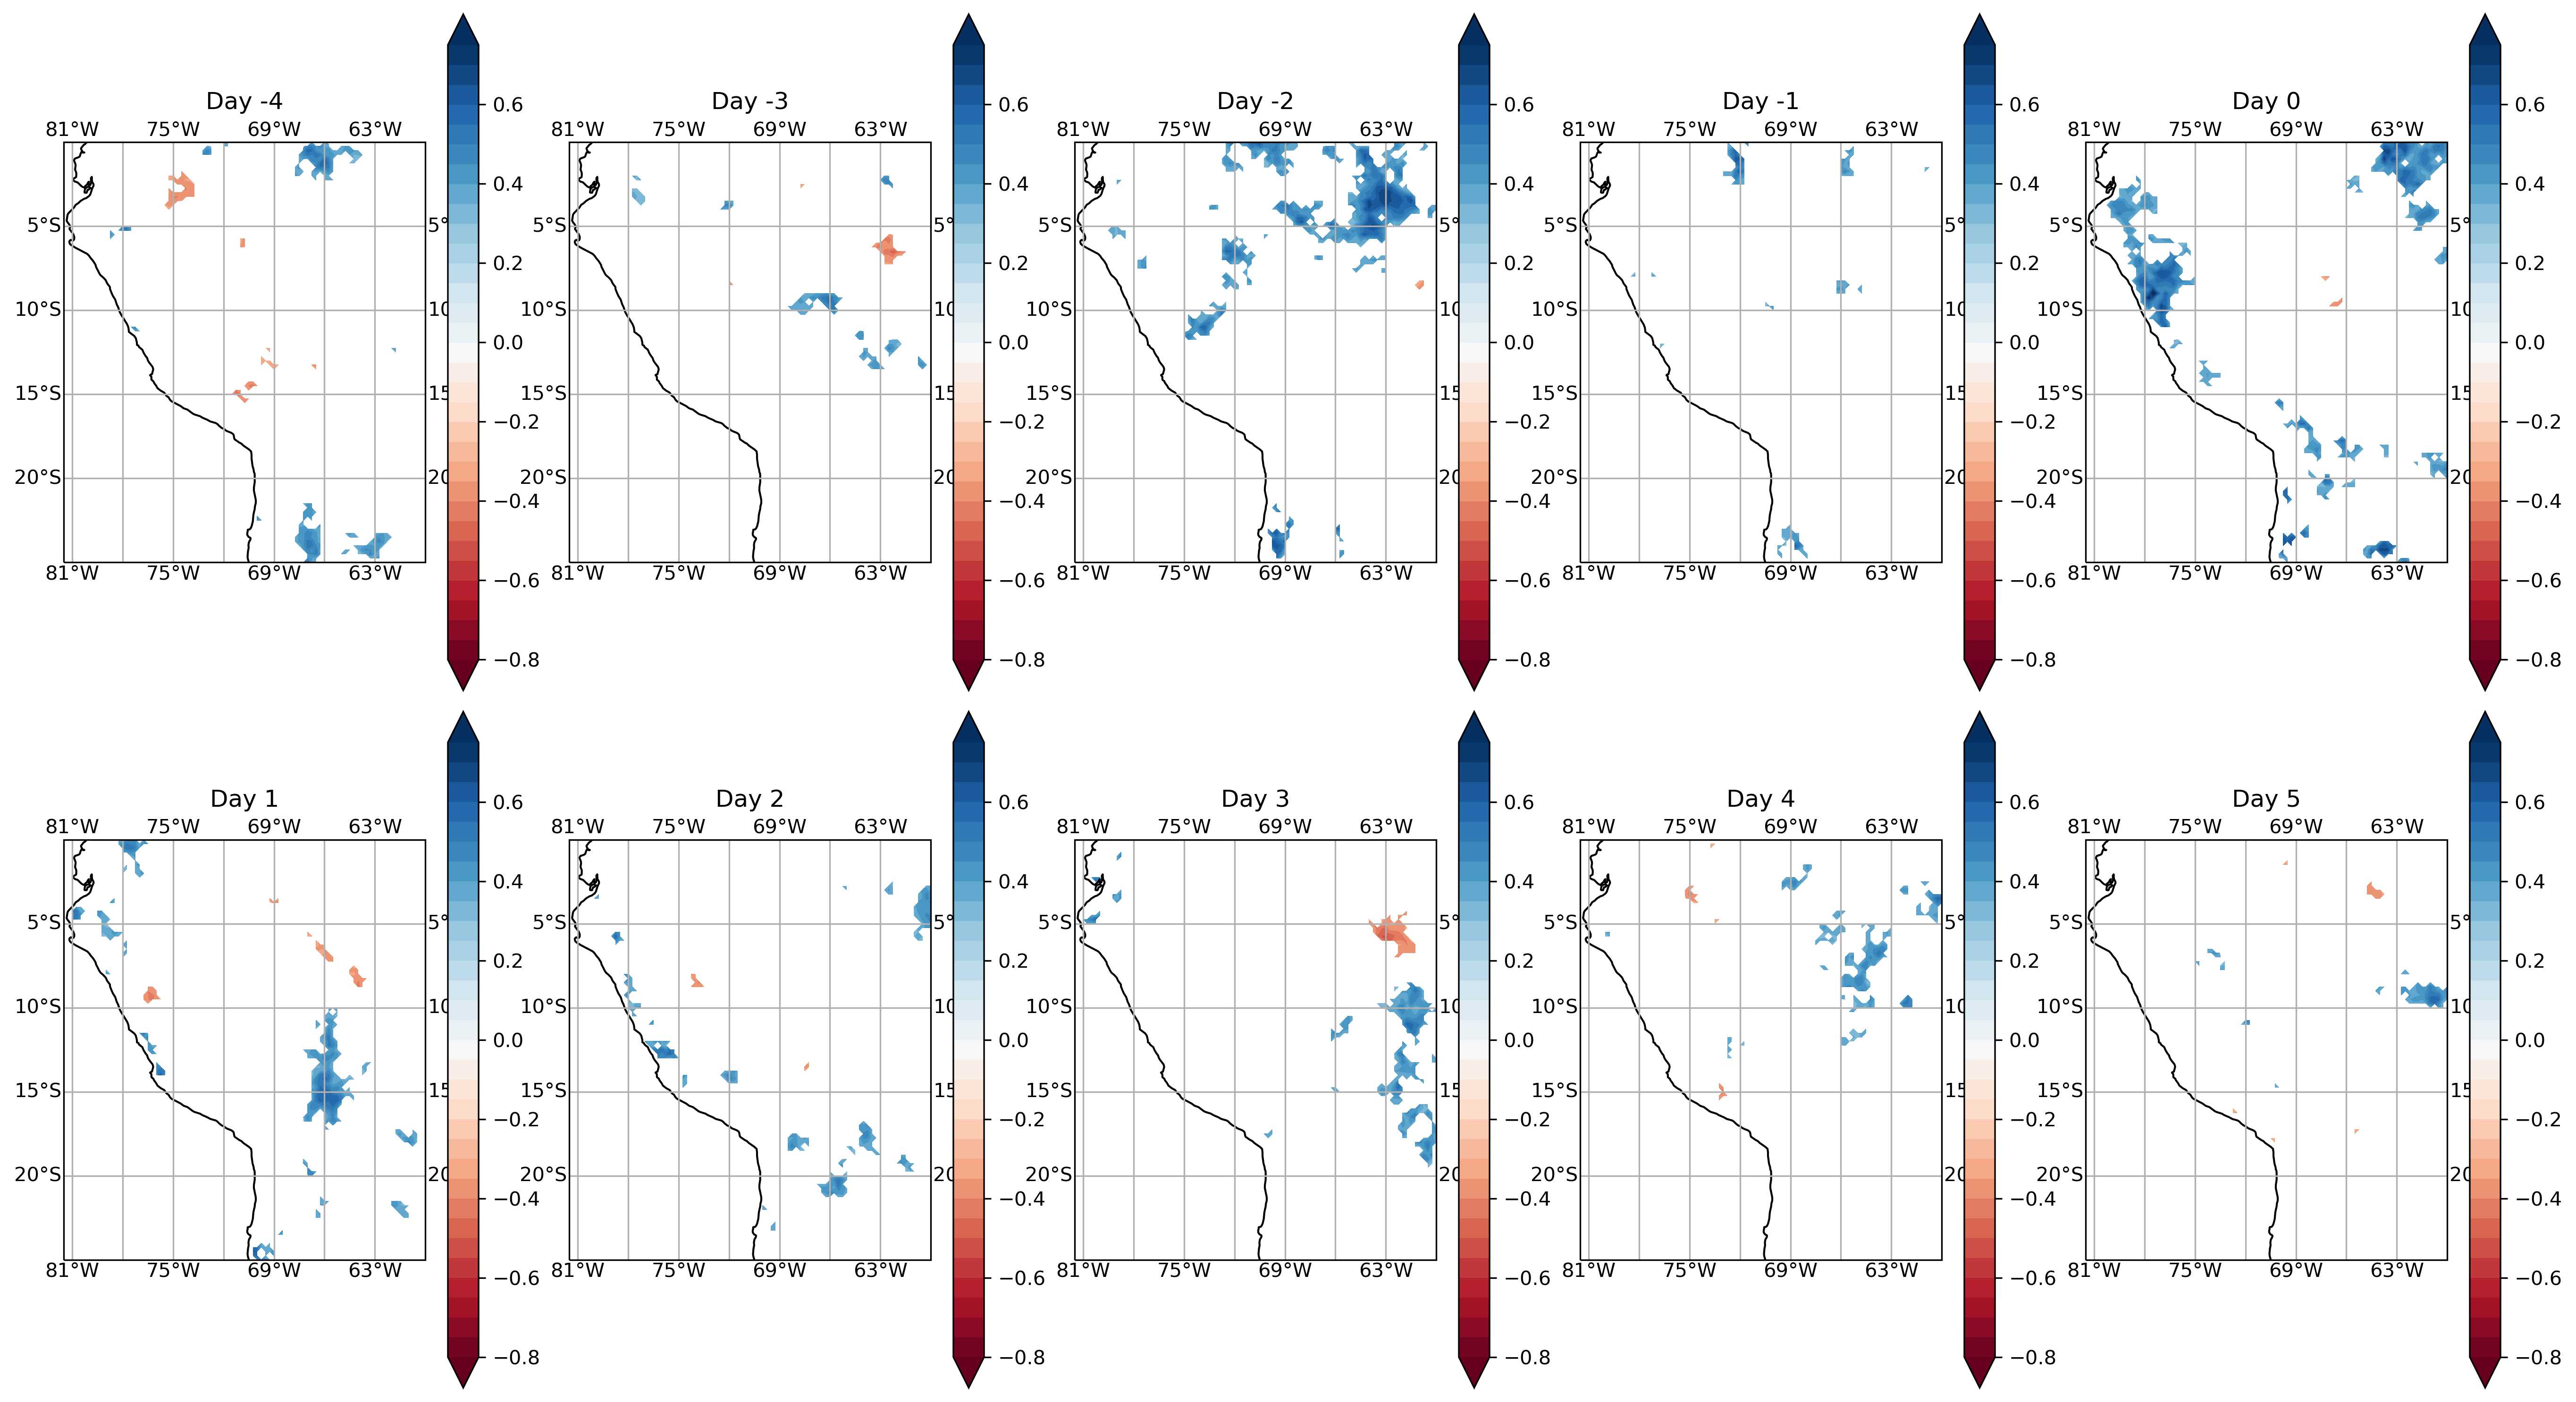

In [43]:
f = plt.figure(figsize=(18,10), dpi=300)

count = np.arange(-4, 6)

for ids in np.arange(len(series_pd)):
    
    ax = f.add_subplot(2,5,ids+1, projection=ccrs.PlateCarree())
    ax.set_ylim(-25,0)
    ax.set_xlim(-81.5,-60)

    mp = ax.contourf(series_pd[ids].longitude, series_pd[ids].latitude, series_pd[ids]['r'].where(series_pd[ids]['pval']<=0.05), levels=np.arange(-0.8,0.8,0.05), cmap='RdBu', extend='both', transform=ccrs.PlateCarree())

    plt.colorbar(mp)

    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    
    plt.title('Day '+str(count[ids]))
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/tcwv_temporal_corr_progression_rioSanta.jpg')

In [176]:
# calculates timeseries correlation of -/+ 5 days around extreme dates with lag option
def apply_ts_corr(ds1,ts, xdate,minus='0days', plus='0days'):

    dates = xdate.where(np.isfinite(xdate), drop=True)
    
    def get_dates(ts_xy, dates, minus=minus, plus=plus):
        ll = []
        for dd in dates:
            t1 = dd -pd.Timedelta(minus) + pd.Timedelta(plus)  -pd.Timedelta('5days')
            t2 = dd -pd.Timedelta(minus) + pd.Timedelta(plus)  +pd.Timedelta('5days')
            
            sliced = ts_xy.sel(time=slice(t1,t2))
            nslice = sliced.assign_coords({'time':np.arange(-5,6)})
            ll.append(nslice)
        return xr.concat(ll, dim='cases').mean('cases')
    
    over = np.intersect1d(ds1.where(np.isfinite(ds1), drop=True).time, ts.where(np.isfinite(ts), drop=True).time)
    ds_11 = ds1.sel(time = over)
    tss = ts.sel(time=over)
    
    ts_slice = get_dates(ts, dates, minus='0days', plus='0days')
    
    ##########
    
    ds = xr.Dataset()
    ds['pval'] = ds1.copy(deep=True).sum('time') * np.nan
    ds['r'] = ds1.copy(deep=True).sum('time') * np.nan
    ds['slope'] = ds1.copy(deep=True).sum('time') * np.nan
   
    for lat in ds1.latitude.values:
        for lon in ds1.longitude.values:

            aa = ds1.sel(latitude=lat, longitude=lon)
            aa_slice = get_dates(aa, dates, minus=minus, plus=plus)
            #ipdb.set_trace()
            pf, intercept, r, p, std_err = stats.linregress(aa_slice.values, ts_slice.values)

            slope = pf

#             if (np.nansum(aa.values == 0) >= 10):
#                 p = np.nan
#                 r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [179]:
# calculate lagged timeseries correlation +/- 5 days
series = []
for num in np.arange(0,5)[::-1]:
    series.append(apply_drywet_ts(ca['precip'], ca_rio_ts['precip'], month_ca.time , minus=str(num)+'days', plus='0days')) #maps
for num in np.arange(1,6):
    series.append(apply_drywet_ts(ca['precip'], ca_rio_ts['precip'], month_ca.time , minus='0days', plus=str(num)+'days'))

In [172]:
#save correlated timeseries
#pkl.dump(series, open(cnst.DATA + 'HUARAZ/emily_test/feb_tcw_temporal_corr.p', "wb"))

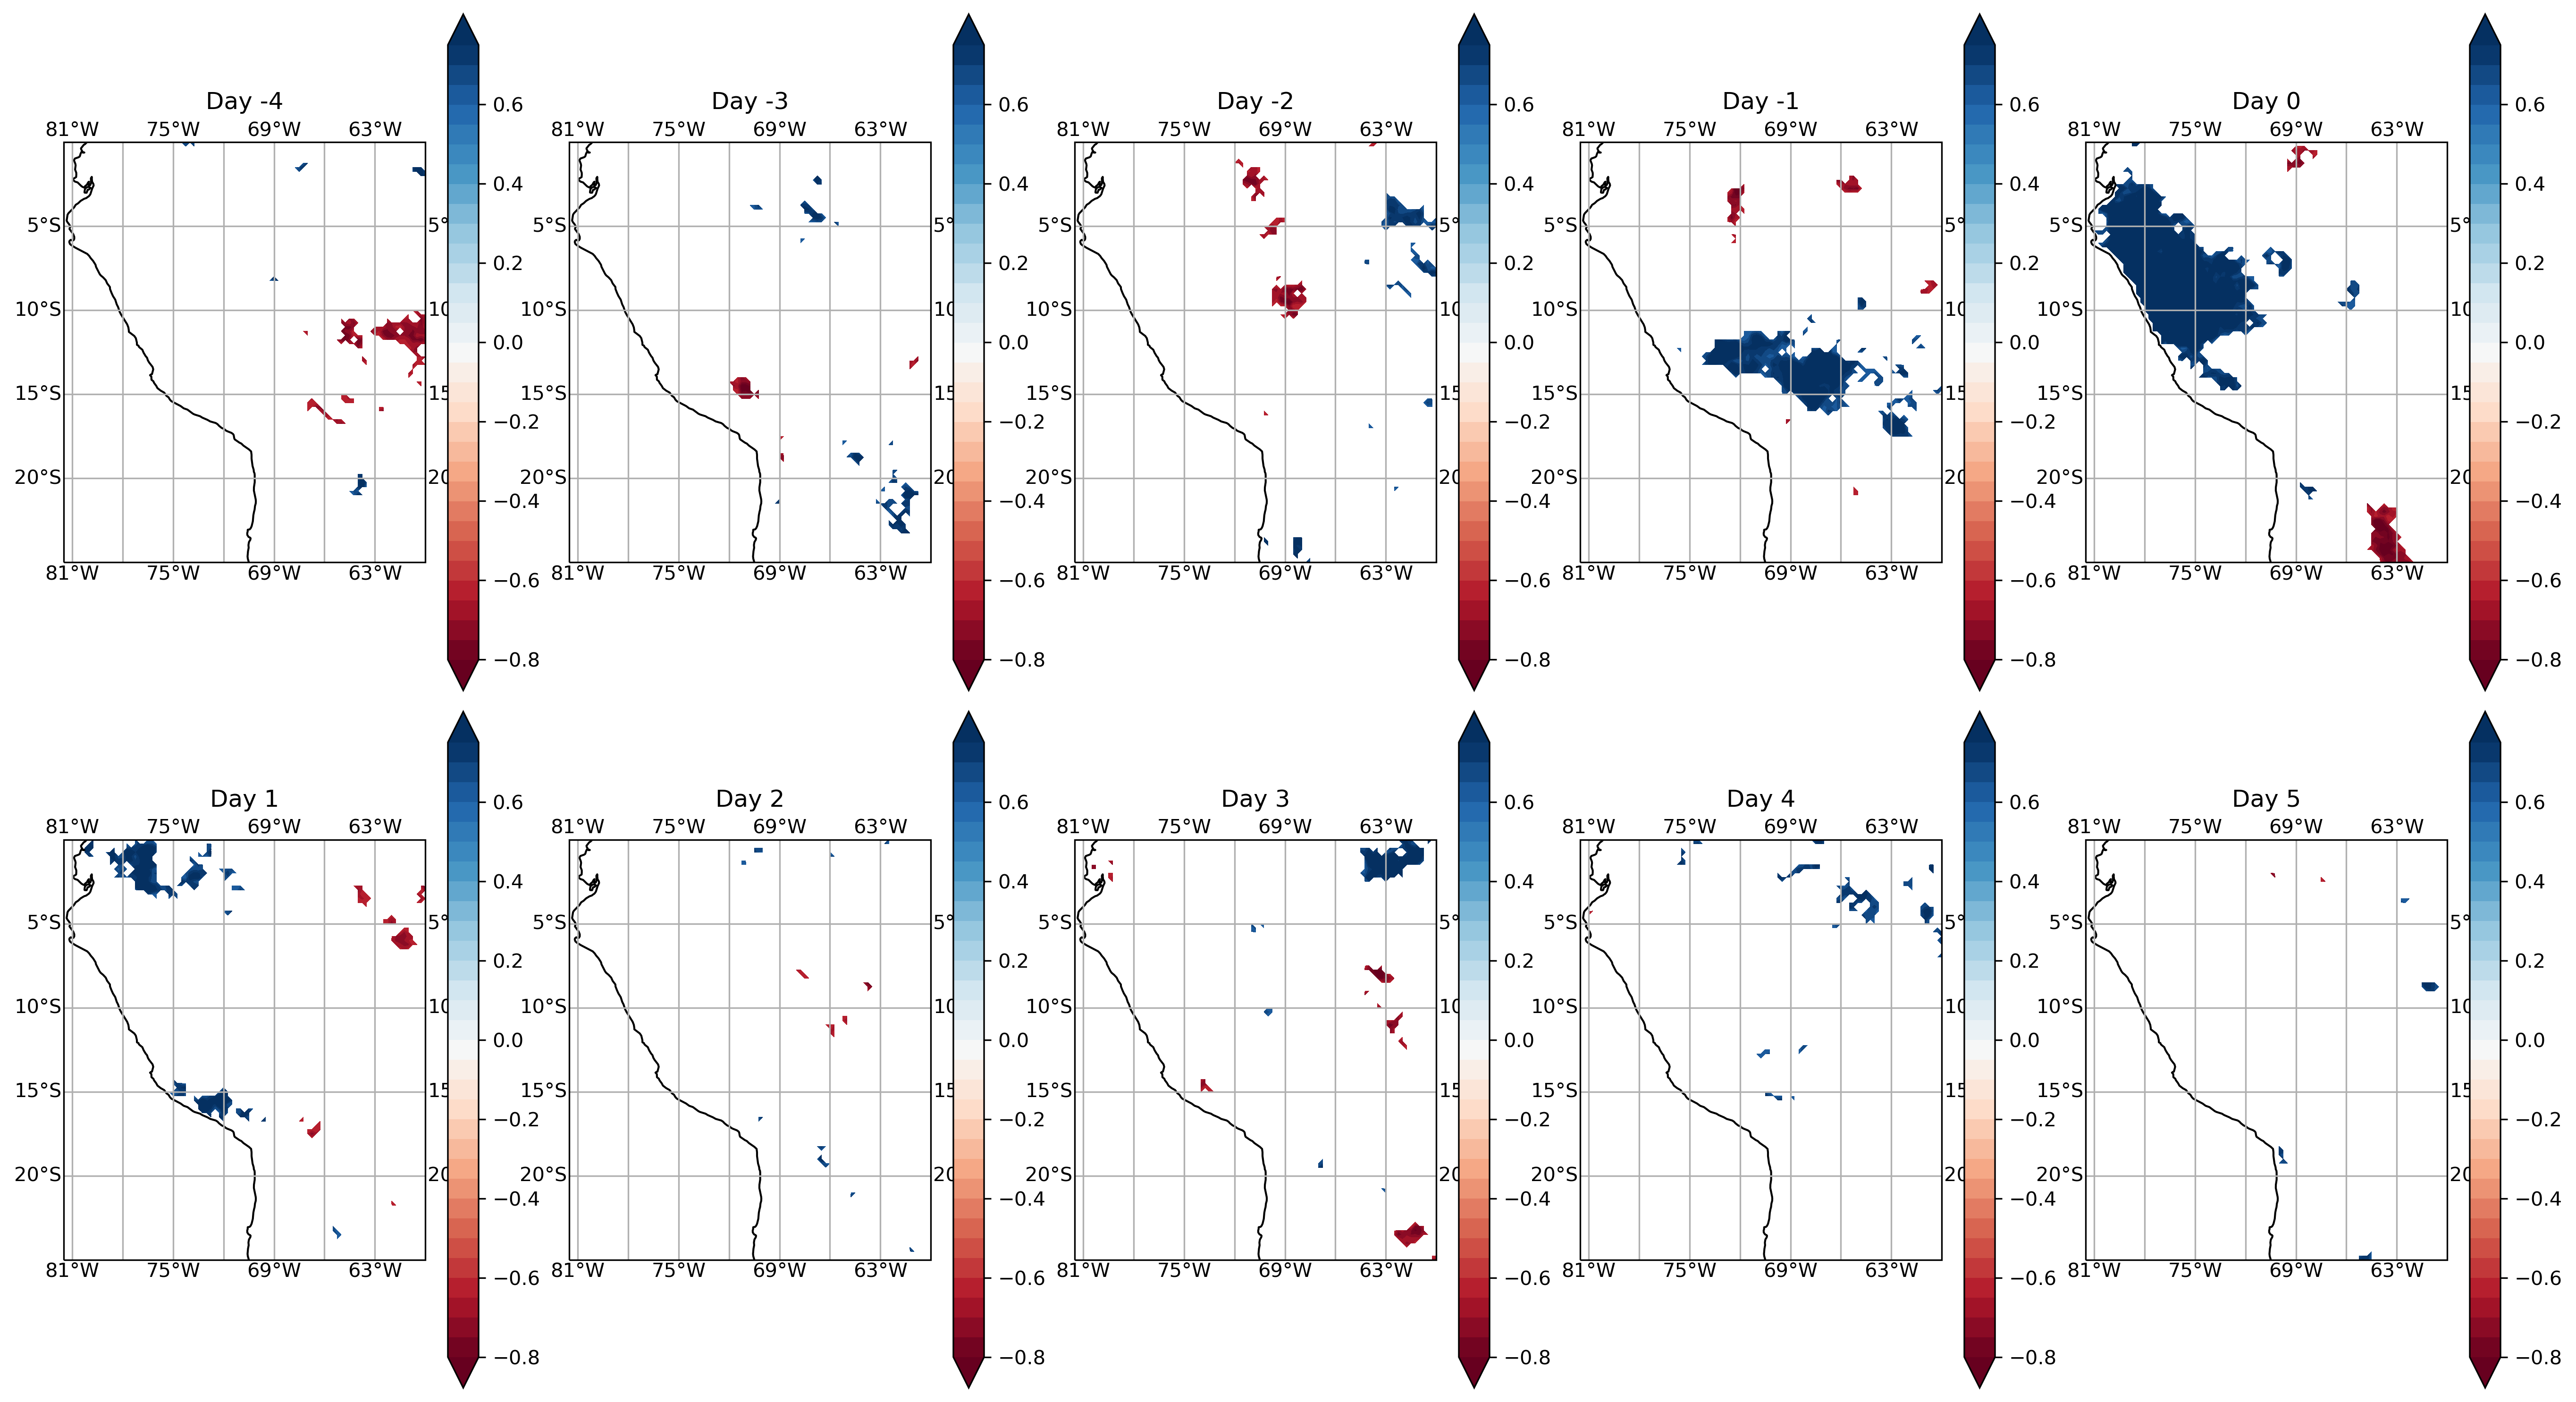

In [180]:
f = plt.figure(figsize=(18,10), dpi=300)

count = np.arange(-4, 6)

for ids in np.arange(len(series)):
    
    ax = f.add_subplot(2,5,ids+1, projection=ccrs.PlateCarree())
    ax.set_ylim(-25,0)
    ax.set_xlim(-81.5,-60)

    mp = ax.contourf(series[ids].longitude, series[ids].latitude, series[ids]['r'].where(series[ids]['pval']<=0.05), levels=np.arange(-0.8,0.8,0.05), cmap='RdBu', extend='both', transform=ccrs.PlateCarree())

    plt.colorbar(mp)

    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    
    plt.title('Day '+str(count[ids]))
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/tcwv_temporal_corr_progression_rioSanta.jpg')

In [ ]:
#calculates difference between day 0 and lagged days
def apply_diff(ds, ts,minus='0days', plus='0days'):

    dates = ts.where(np.isfinite(ts), drop=True).time
    wds = dates -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    wd_true = dates 
    
    print('wet', len(wds), len(wd_true))
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    wd_true = wd_true[x_ind]
    print('wet2', len(wds))

    all_wet = ds.sel(time=wds).mean('time') - ds.sel(time=wd_true).mean('time')
    
    return all_wet

In [40]:
# calculates differences for +/- 5 days
diffseries = []
for num in np.arange(0,5)[::-1]:
    diffseries.append(apply_diff(maps, month,  minus=str(num)+'days', plus='0days'))
for num in np.arange(1,6):
    diffseries.append(apply_diff(maps, month, minus='0days', plus=str(num)+'days'))

wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37
wet 42 42
wet2 37


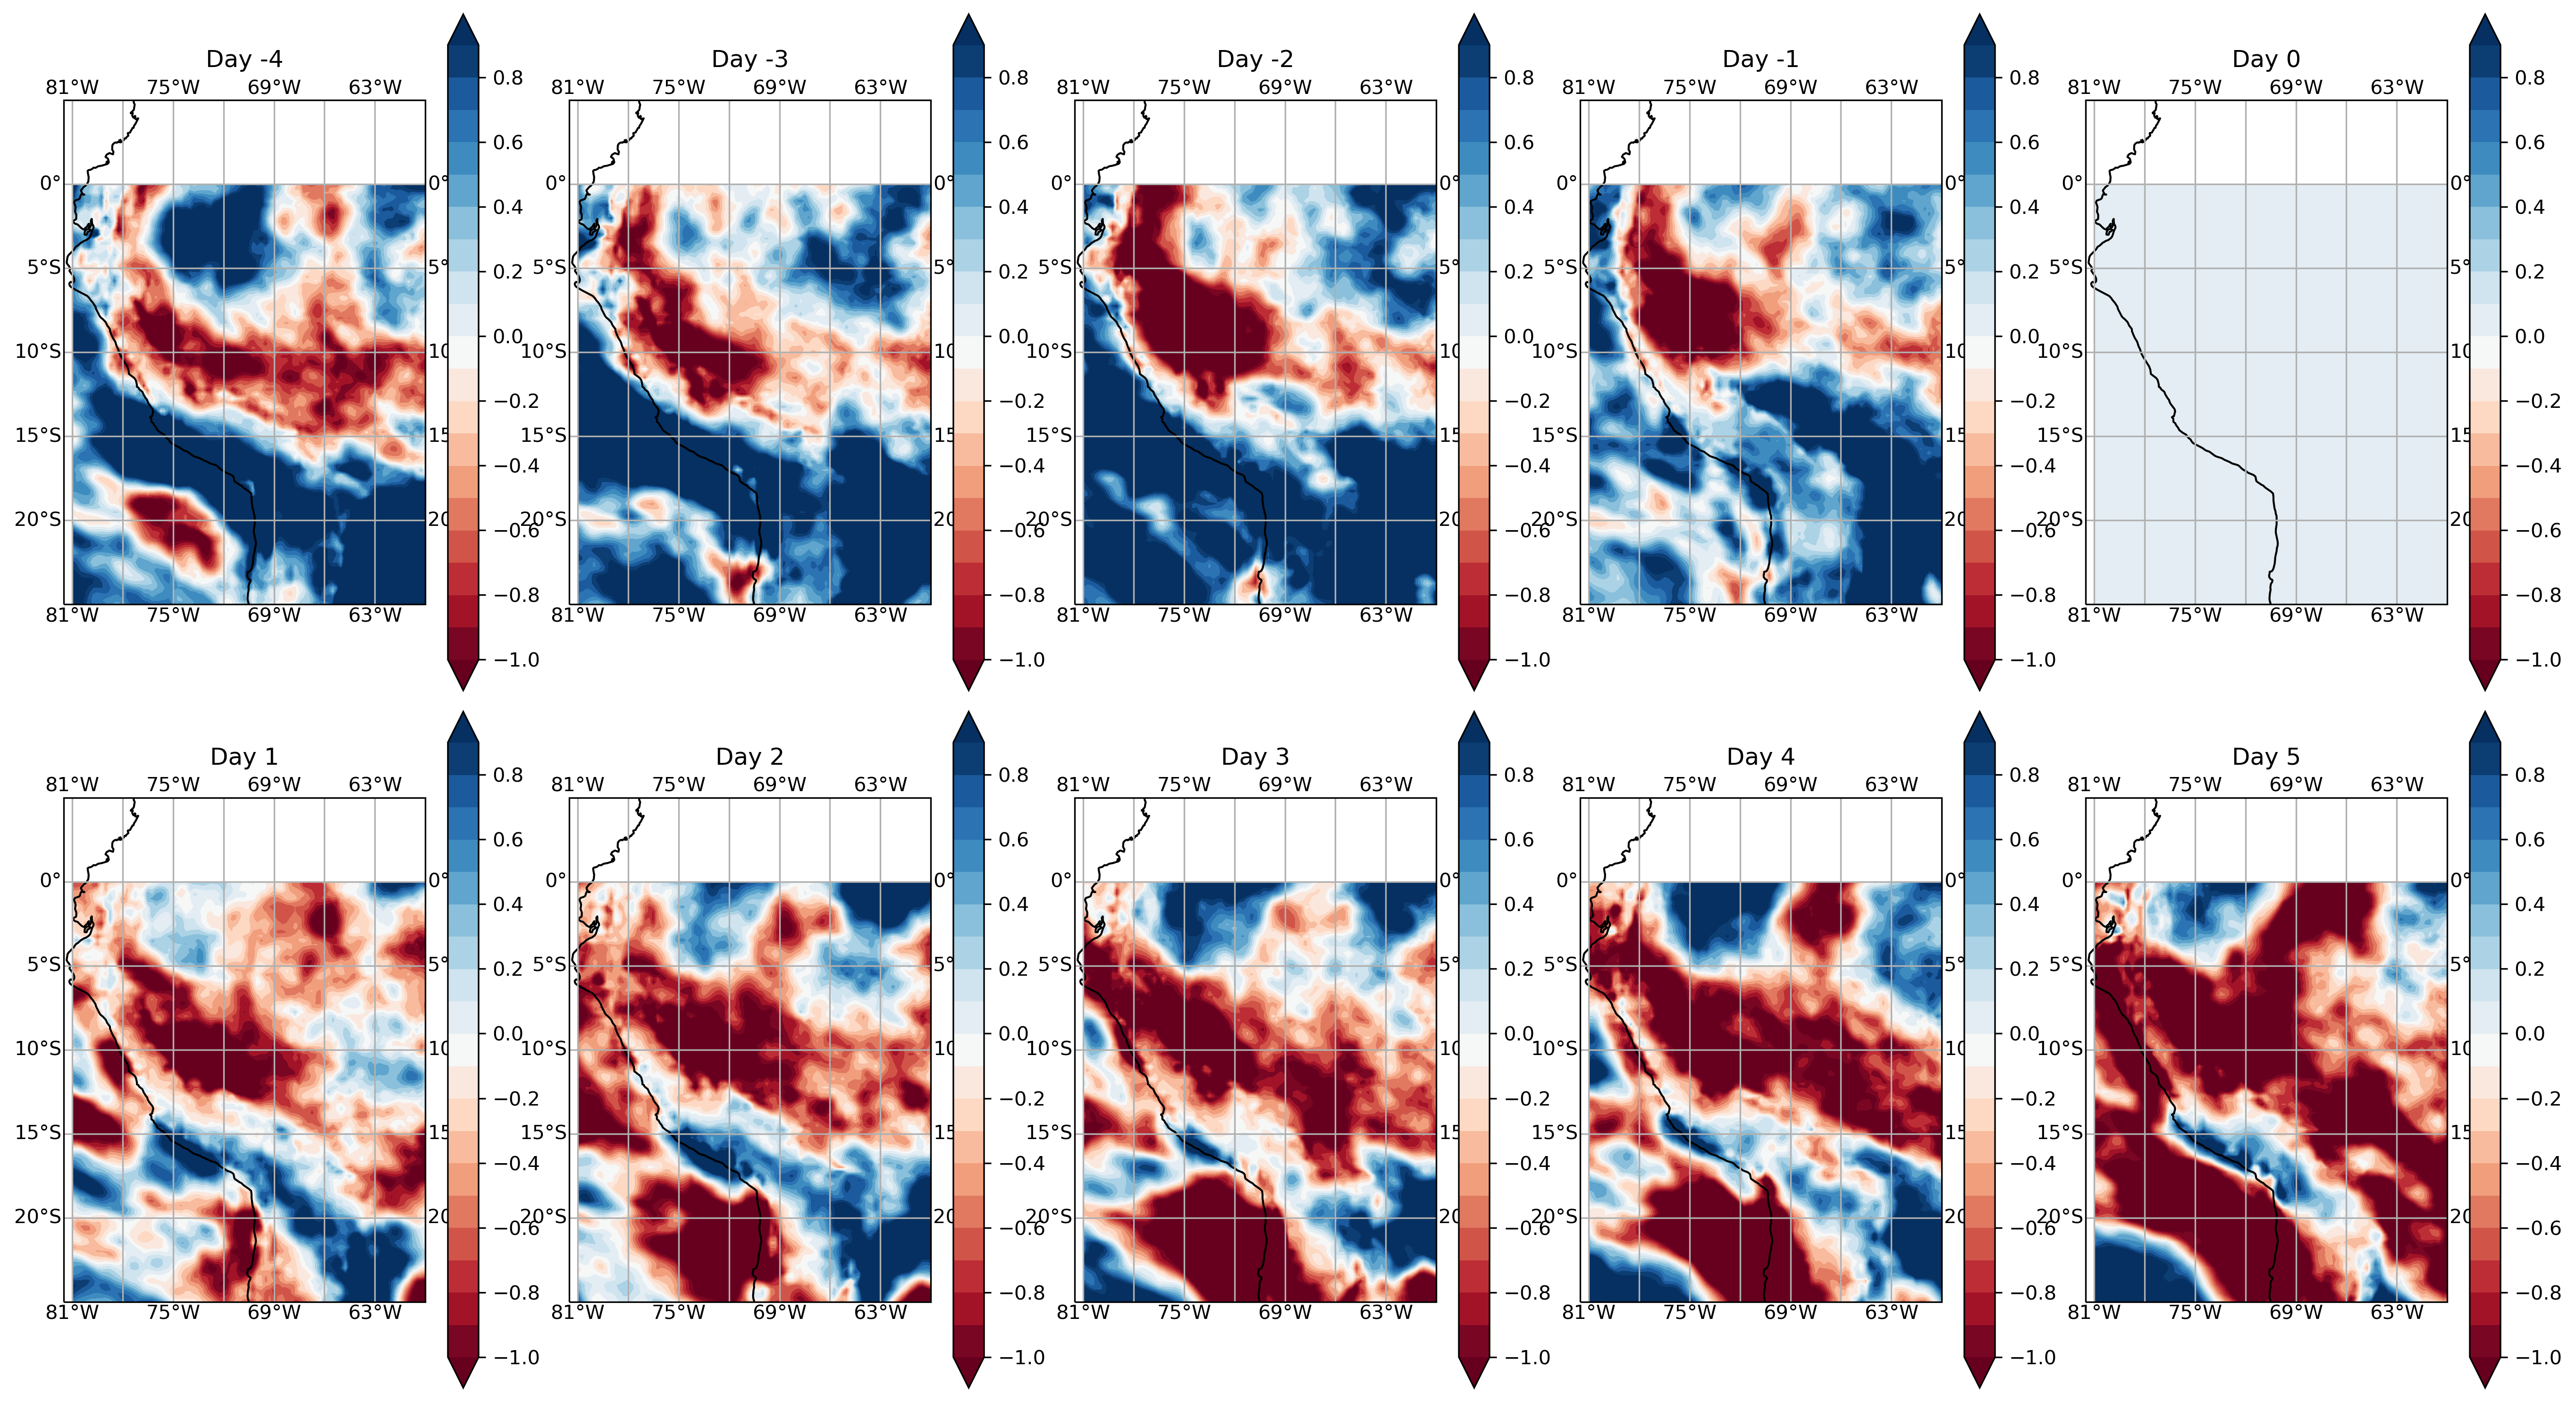

In [43]:
f = plt.figure(figsize=(18,10), dpi=300)

count = np.arange(-4, 6)

for ids in np.arange(len(diffseries)):
    
    ax = f.add_subplot(2,5,ids+1, projection=ccrs.PlateCarree())
    ax.set_ylim(-25,5)
    ax.set_xlim(-81.5,-60)

    mp = ax.contourf(diffseries[ids].longitude, diffseries[ids].latitude, diffseries[ids], levels=np.arange(-1,1,0.1), cmap='RdBu', extend='both', transform=ccrs.PlateCarree())

    plt.colorbar(mp)

    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    
    plt.title('Day '+str(count[ids]))
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/tcwv_difference_progression_rioSanta.jpg')